<a href="https://colab.research.google.com/github/adi2003/Customer_Segmentation_K-Means/blob/main/Customer_Segmentation_K_Mean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [ ]:
# uploading the data onto google colab
from google.colab import files
uploaded = files.upload()

Saving Online Retail.xlsx to Online Retail.xlsx


In [ ]:
# Converting the Excel file to a pandas Dataframe
df = pd.read_excel('Online Retail.xlsx')

In [ ]:
#printing 10 randomly chosen sample data points
df.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
67755,541845,84876D,BLUE HEART COMPACT MIRROR,1,2011-01-23 12:41:00,3.75,15167.0,United Kingdom
228707,556942,21878,PACK OF 6 SANDCASTLE FLAGS ASSORTED,12,2011-06-15 16:42:00,0.85,14222.0,United Kingdom
118509,546435,21212,PACK OF 72 RETROSPOT CAKE CASES,24,2011-03-14 09:37:00,0.55,15671.0,United Kingdom
264967,560186,21793,CLASSIC FRENCH STYLE BASKET BROWN,1,2011-07-15 11:57:00,3.95,17266.0,United Kingdom
110956,545702,22727,ALARM CLOCK BAKELIKE RED,1,2011-03-06 15:21:00,3.75,14247.0,United Kingdom
266582,560260,85014A,BLACK/BLUE POLKADOT UMBRELLA,1,2011-07-17 13:32:00,5.95,14044.0,United Kingdom
10313,537237,21359,RELAX LARGE WOOD LETTERS,1,2010-12-06 09:58:00,34.00,NaN,United Kingdom
84182,543370,22926,IVORY GIANT GARDEN THERMOMETER,2,2011-02-07 14:51:00,5.95,12359.0,Cyprus
148551,549242,84279P,CHERRY BLOSSOM DECORATIVE FLASK,4,2011-04-07 11:41:00,3.75,14911.0,EIRE
397780,571205,23048,SET OF 10 LANTERNS FAIRY LIGHT STAR,4,2011-10-14 12:41:00,4.15,15620.0,United Kingdom


In [ ]:
df.info()
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
(541909, 8)


Before we go any further,lets get to know the data a little more.Lets discuss what each of the columns represents:

*   The Dataframe has **541909 rows** and **8 columns**.

**Columns Description**

1.   **InvoiceNo** : Unique ID for every time a consumer visits the store
2.   **StockCode**: Unique ID for a product
3.   **Description** : Description of the product
4.   **Quantity** : No of units bought
5.   **InvoiceDate** : Date and time of purchase
6.   **Unit Price** : Price for 1 unit of the product
7.  **CustomerId**: Unique ID for each customer
8.   **Country** : Country where transaction happened















**DATA CLEANING**

We need to clear any anomalies in the data so that we can easily work with the data.

In [ ]:
#here we can check the number of null rows corresponding to each column
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
#copying df to customer_df so that we dont have to load the data multiple times
#if we change something with the data without losing the original data
#since later we won't need any of the columns that have null values we don't need to drop any rows

customer_df=df

**FEATURE ENGINEERING**

We need to select and generate features using the given features that are most suited for segmenting the customers based on the RFM customer segmentation model using **K-Mean Clustering**. We will be making 3 features that are part of the **RFM model**,that are:

1.   **Recency**: Recency is calculated as the number of days since the last purchase by a particular customer.
2.   **Frequency**: Frequency is the number of times a particular customer has purchased from the store.
3.   **Monetary** : It is the total monetary value that the customer has generated for the store.

In [ ]:
# RFM Feature Engineering
# get the Total Price of each order which is basically the quantity of the ite, times the price of one unit of the item
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# creating new features for customer_df that match correspond to the various components of RFM segmentation strategy
# we group the customers by CustomerID so that one group represents one customer
# and then we calculate the recency,frequency and total price for each customer as discussed above
customer_df = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (df['InvoiceDate'].max() - x.max()).days,
                                            'InvoiceNo': 'count',
                                            'TotalPrice': 'sum'})

# renaming the features to what they represent
customer_df.rename(columns={'InvoiceDate': 'recency'}, inplace=True)
customer_df.rename(columns={'InvoiceNo': 'frequency',}, inplace=True)
customer_df.rename(columns={'TotalPrice': 'monetary'}, inplace=True)


print("Total number of customers: ",customer_df.shape[0])
customer_df.head()


Total number of customers:  4372


,recency,frequency,monetary
CustomerID,,,
12346.0,325,2,0.00
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40


We notice that the values in the columns of recency,frequency and monetary values are quite different from each other. If we try to train the data with such values we wont get satisfying results.

 so I decided to scale it down.Since we want to just scale down the data and not necessarily about the mean so we want to use the following formula on each data point in the customer_df dataframe.

**minimum** = **min**(**Xi**)

**maximum** = **max**(**Xi**)

**Xi** = (**Xi** - **minimum**)/(**maximum** - **minimum**)

The same is achieved by using the **MinMaxScaler().fit_transform()** function of the scikit-Learn library.It uses the maximum and minimum within each column.


In [ ]:
# we create a new numpy array where each column of the customer_df dataframe is transformed by scaling it.
norm_customer = MinMaxScaler().fit_transform(customer_df)

#norm_customers is a 2-D array with each 1-D array that is part of the 2-D array a scaled row of the customer_df dataframe.
# lets look at the shape of the norm_customer array
print(norm_customer.shape)

# printing the norm_customer numpy array
norm_customer

(4372, 3)


array([[8.71313673e-01, 1.25281884e-04, 1.51091712e-02],
       [2.68096515e-03, 2.26760210e-02, 3.02971721e-02],
       [1.98391421e-01, 3.75845653e-03, 2.14424619e-02],
       ...,
       [1.87667560e-02, 1.50338261e-03, 1.57314917e-02],
       [8.04289544e-03, 9.45878226e-02, 2.24913149e-02],
       [1.12600536e-01, 8.64445001e-03, 2.15835588e-02]])

**FINDING THE RIGHT NUMBER OF CLUSTERS**

Now we find the **number of clusters that will correctly represent the data**.

We want **low number of clusters and low inertia** values for the model to be good.

**Inertia values** are basically the **variation of the points from their respective cluster means**(also called **centroids**)

In [ ]:
# fitting the model with different number of clusters to check for the right number of clusters
# we need to store the inertia values as discussed above
# we find the inertia values for the different n_cluster values.
inertias = []

for k in range(1, 11):
    #training the KMeans Model for different n_cluster values
    kmeans = KMeans(n_clusters=k, n_init=20)
    kmeans.fit(norm_customer)
    #here we append the inertia values
    inertias.append(kmeans.inertia_)

# here is the inertia vector containing the inertia values
inertias

[326.37135032944195,
 72.7937979957681,
 38.18554266730418,
 24.700461203391193,
 17.956251597788714,
 14.606228031007689,
 11.259650641720487,
 9.391451516389854,
 8.017033417631936,
 6.828389791174008]

Text(0.5, 1.0, 'Elbow plot')

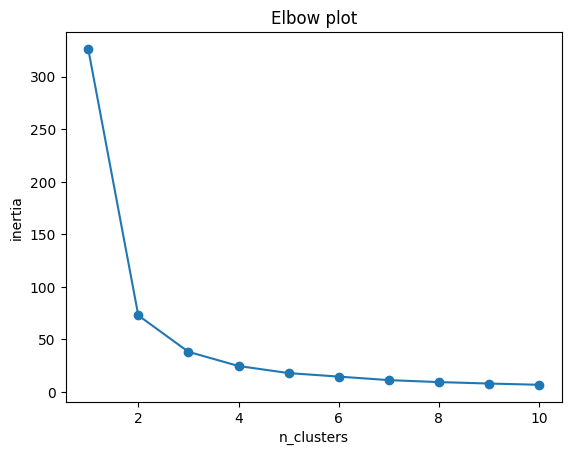

In [ ]:
# create inertias elbow plot
plt.plot(range(1, 11), inertias, marker='o')

plt.xlabel('n_clusters')
plt.ylabel('inertia')
plt.title('Elbow plot')


**SELECTING THE RIGHT NUMBER OF CLUSTERS**

We should the select the value of number of clusters using the elbow plot **where the inertia values stop decreasing significantly**.So using the plot above there are two values that I decided to consider.These are **number of clusters(k)=3 or 4**. We evaluate both of them.

Lets start by evaluating k=4

In [ ]:
# create the final kmeans model
final_kmeans = KMeans(n_clusters=4, n_init=20)

final_kmeans.fit(norm_customer)

KMeans(n_clusters=4, n_init=20)

In [ ]:
#creating the final dataframe containing the cluster labels generated by the K-mean Clustering model
final_df = pd.DataFrame(norm_customer, columns=customer_df.columns, index=customer_df.index)

final_df['cluster'] = final_kmeans.labels_

final_df

,recency,frequency,monetary,cluster
CustomerID,,,,
12346.0,0.871314,0.000125,0.015109,3
12347.0,0.002681,0.022676,0.030297,2
12348.0,0.198391,0.003758,0.021442,0
12349.0,0.048257,0.009020,0.021303,2
12350.0,0.828418,0.002005,0.016288,3
...,...,...,...,...
18280.0,0.742627,0.001128,0.015746,3
18281.0,0.482574,0.000752,0.015394,1
18282.0,0.018767,0.001503,0.015731,2


In [ ]:
#printing the number of customers in each of the clusters obtained after K-Mean Clustering
print(final_df['cluster'].value_counts())
print_a=final_df['cluster'].value_counts()
indexes=print_a.index
print(indexes)
print_a=np.array(print_a)

2    2185
0    1059
1     622
3     506
Name: cluster, dtype: int64
Int64Index([2, 0, 1, 3], dtype='int64')


   cluster   recency  frequency  monetary
0        0  0.214629   0.006432  0.018533
1        1  0.509086   0.004249  0.017181
2        2  0.047715   0.018104  0.025952
3        3  0.828021   0.002783  0.016377


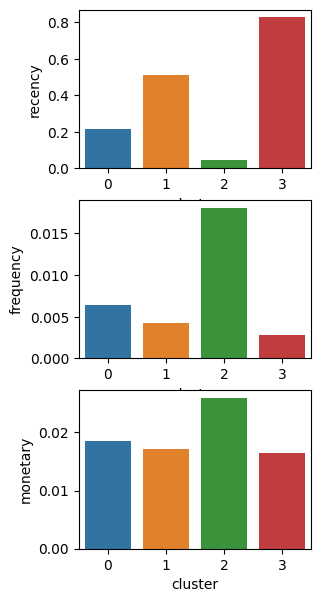

In [ ]:
# now we need calculate the cluster mean values for each cluster and each category/cluster
cluster_mean = final_df.groupby('cluster')[['recency', 'frequency', 'monetary']].mean().reset_index()

print(cluster_mean)

fig, axes = plt.subplots(nrows=3, figsize=(3, 7))

# barplotting the different clusters in context of recency,frequency and monetary value
sns.barplot(cluster_mean, x='cluster', y='recency', ax=axes[0])
sns.barplot(cluster_mean, x='cluster', y='frequency', ax=axes[1])
sns.barplot(cluster_mean, x='cluster', y='monetary', ax=axes[2])

plt.show()

**OBSERVATIONS**

We are done with most of the analysis and here are the results.We have successfully divided the data points i.e our customers into 4 clusters and Now its time that we evaluate the characteristics of each of these clusters. Here are the observations:

1.   **Cluster 2**: Cluster 2 bar plot gives us a pretty good idea of what it represents.We notice that it has low recency,high frequency and high monetory value.These are the regular customers that are providing us with the most monetary gains.We conclude that most of our customers are loyal ,regular and extremely valuable monetarily as well.We should make sure that these customers stick with us.
2.   **Cluster 0**:  Cluster 0 is definitely our second best category of customers with second highest monetory value generators.They have a good recency value so they are not lost as such but there low frequency indicates that these customers are not very frequent.Maybe we should try to get them come by more frequently.
3.   **Cluster 1**: Cluster 1 consists of customers that have slightly better performing for us than Cluster 3 customers in terms of recency,frequency,monetory value.These customers fall in the vulnerable category and definitely are on the verge of becoming non-customers.So they are the ones we should be most focussed on.
4.   **Cluster 3**: Cluster 3 customers are basically lost customers because there high recency shows that they have not been visiting recently. Moreover they are the least frequent visitors.They bring in the least amount of money to us.So they are long lost.

To further look at the results visually lets make a 3-Dimensional plot of all the customers against the parameters we analysed.



In [ ]:
sns.set_style('whitegrid')

<class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>


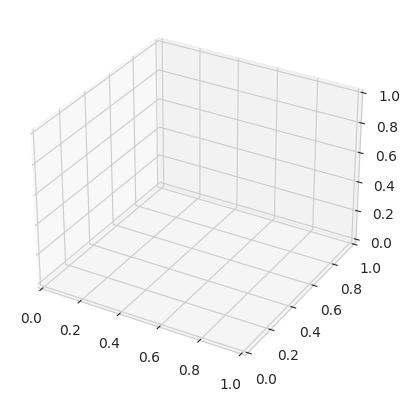

In [ ]:
plot_axes=plt.axes(projection='3d')
print(type(plot_axes))

In [ ]:
# making the different arrays corresponding to R,F,M
x=np.array(customer_df['recency'])
y=np.array(customer_df['frequency'])
z=np.array(customer_df['monetary'])
w=np.array(final_df['cluster'])

# printing the values
print(x)
print(y)
print(z)
print(w)

# scatter-plotting the values generated above
plot_axes.scatter3D(x,y,z)
plot_axes.set_xlabel('x')
plot_axes.set_ylabel('y')
plot_axes.set_zlabel('z')

[325   1  74 ...   7   3  42]
[  2 182  31 ...  13 756  70]
[   0.   4310.   1797.24 ...  176.6  2094.88 1837.28]
[3 2 0 ... 2 2 2]


Text(0.10787434422876363, 0.014452421710067028, 'z')

<class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>


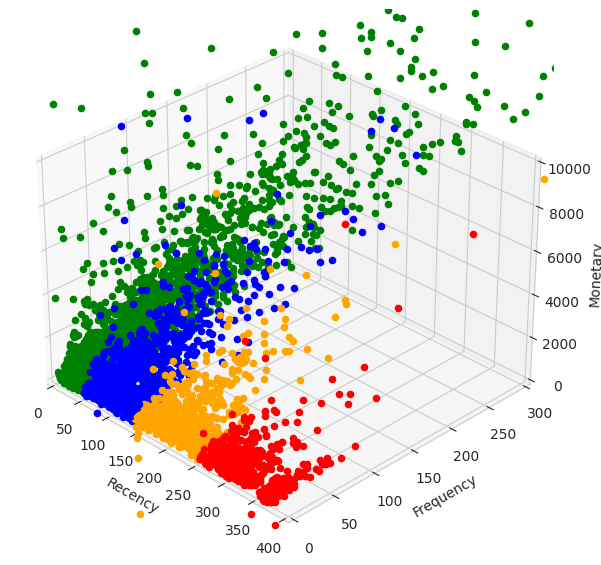

In [ ]:
#creating a 3-D plot for the points.
sns.set_style ("whitegrid")
plt.figure (figsize = (7, 9))
seaborn_plot = plt.axes (projection='3d')
print (type (seaborn_plot))

#plotting all the points ,colour coding them same as that in the bar graph
for i in range(w.shape[0]):
  if(w[i]==0):
    seaborn_plot.scatter3D (x[i],y[i],z[i],c='b')
  if(w[i]==1):
    seaborn_plot.scatter3D (x[i],y[i],z[i],c='orange')
  if(w[i]==2):
    seaborn_plot.scatter3D (x[i],y[i],z[i],c='g')
  if(w[i]==3):
    seaborn_plot.scatter3D (x[i],y[i],z[i],c='r')

#The axes for the 3-Dimensions would be x:Recency,y:Frequency and z:Monetory value
seaborn_plot.set_xlabel ('Recency')
seaborn_plot.set_ylabel ('Frequency')
seaborn_plot.set_zlabel ('Monetary')

# scaling the values to necessary levels so that we can make a reasonable plot
seaborn_plot.set_xlim3d(0, 400)
seaborn_plot.set_ylim3d(0, 300)
seaborn_plot.set_zlim3d(0, 10000)
seaborn_plot.view_init(elev=30, azim=-45)
plt.show ()

The 3-D dimensional plot clearly shows the clustering that we talked about.
Let's discuss a little bit about the above plot.

1.   The points that are the leftmost are the most loyal customers that   are highly valueable to the shop

2.   Notice how those points are spread to range with very high frequency that to very high monetory levels on the z-axis.These features indicated in the 3-D plot indicate how these are the best customers for us.


1.   The rightmost are the ones that are the we earlier presented as long lost customers that do not generate much value

2.   Notice how these points are the rightmost on recency which indicates that they did a transaction long time back.Also notice that the points belonging to that category are mostly low on the z-axis(monetarily) and low on frequency as well.

.The other two clusters are present between the them in the expected order with the better one to left.

Now we will be doing similar analysis for the case where we divide our data into 3 clusters.

In [ ]:
# create the final kmeans model now for number of clusters=3
# again constructing tha model having 3 clusters using the scikit-Learn K-means.
final_kmeans = KMeans(n_clusters=3, n_init=20)

#fitting the model on the normal customer dataframe.
final_kmeans.fit(norm_customer)

KMeans(n_clusters=3, n_init=20)

In [ ]:
# again constructing a dataframe that will contain the prevous information from the norm_customer dataframe and adding the cluster information
final_df = pd.DataFrame(norm_customer, columns=customer_df.columns, index=customer_df.index)

#adding the cluster values to the dataframe final_df.
final_df['cluster'] = final_kmeans.labels_

#printing the final dataframe
final_df

,recency,frequency,monetary,cluster
CustomerID,,,,
12346.0,0.871314,0.000125,0.015109,1
12347.0,0.002681,0.022676,0.030297,0
12348.0,0.198391,0.003758,0.021442,0
12349.0,0.048257,0.009020,0.021303,0
12350.0,0.828418,0.002005,0.016288,1
...,...,...,...,...
18280.0,0.742627,0.001128,0.015746,1
18281.0,0.482574,0.000752,0.015394,2
18282.0,0.018767,0.001503,0.015731,0


   cluster   recency  frequency  monetary
0        0  0.080534   0.015254  0.024114
1        1  0.789202   0.002807  0.016536
2        2  0.406255   0.004987  0.017599


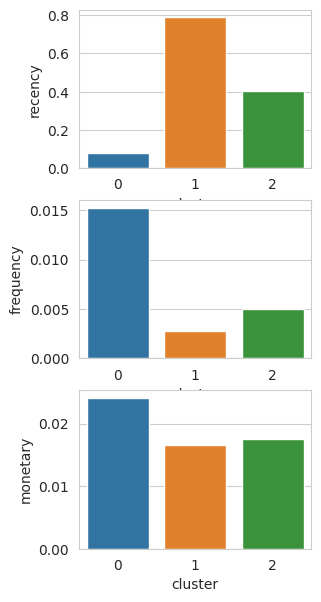

In [ ]:
# we will now calculate which cluster is good in which feature among the 3 features we are considering (i.e recency,frequency and monetary)
# To do this we find out the averages of different parameters in each cluster. we use groupby function of the pandas library

cluster_mean = final_df.groupby('cluster')[['recency', 'frequency', 'monetary']].mean().reset_index()

print(cluster_mean)

fig, axes = plt.subplots(nrows=3,figsize=(3,7))

sns.barplot(cluster_mean, x='cluster', y='recency', ax=axes[0])
sns.barplot(cluster_mean, x='cluster', y='frequency', ax=axes[1])
sns.barplot(cluster_mean, x='cluster', y='monetary', ax=axes[2])
plt.show()

In [ ]:
#printing the number of customers in each of the clusters obtained after K-Mean Clustering
final_df['cluster'].value_counts()

0    2922
2     816
1     634
Name: cluster, dtype: int64

**OBSERVATIONS**

We are now done with the analysis for 3 clusters and here are the results.We have successfully divided the data points i.e our customers into 3 clusters and Now its time that we evaluate the characteristics of each of these clusters. Here are the observations:

1.   **Cluster 0**: Cluster 0 bar plot gives us a pretty good idea of what it represents.We notice that it has low recency,high frequency and high monetory value. Similar to 4-mean clustered plot,These are the regular customers that are providing us with the most monetary gains.We conclude that most of our customers are loyal ,regular and extremely valuable monetarily as well.We should make sure that these customers stick with us.
2.   **Cluster 2**:  Cluster 2 is definitely our second best category of customers with second highest monetory value generators.They have a good recency value so they are not lost as such but there low frequency indicates that these customers are not very frequent.Maybe we should try to get them come more frequently.
3.   **Cluster 1**: Cluster 1 consists of customers that have high recency value,so they haven't shopped recently.Moreover they have the least frequency and the least monetory average returns among the 3 clusters that we generated and so we conclude that these customers are probably lost.But we should to try to do something to bring these old customers back.

Although I notice that most of the customers belong to the first cluster and thus most of our customers are loyal and monetorily high in value.So the store must be doing good.

Now lets try to draw a 3-D plot to see the clustering by plotting the customers against the three features that we have been studying.

In [ ]:
sns.set_style('whitegrid')

<class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>


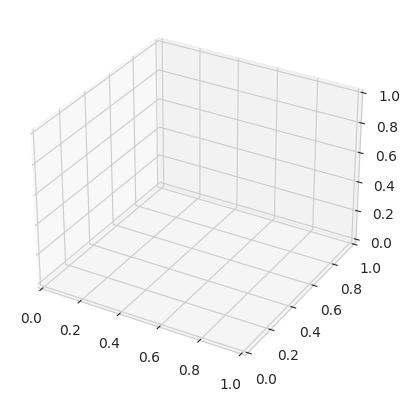

In [ ]:
plot_axes=plt.axes(projection='3d')
print(type(plot_axes))

In [ ]:
# making the different arrays corresponding to R,F,M for 3 clusters
x=np.array(customer_df['recency'])
y=np.array(customer_df['frequency'])
z=np.array(customer_df['monetary'])
w=np.array(final_df['cluster'])

# printing the values
print(x)
print(y)
print(z)
print(w)

# scatter-plotting the values generated above for 3 clusters
plot_axes.scatter3D(x,y,z)
plot_axes.set_xlabel('x')
plot_axes.set_ylabel('y')
plot_axes.set_zlabel('z')

[325   1  74 ...   7   3  42]
[  2 182  31 ...  13 756  70]
[   0.   4310.   1797.24 ...  176.6  2094.88 1837.28]
[1 0 0 ... 0 0 0]


Text(0.10787434422876363, 0.014452421710067028, 'z')

<class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>


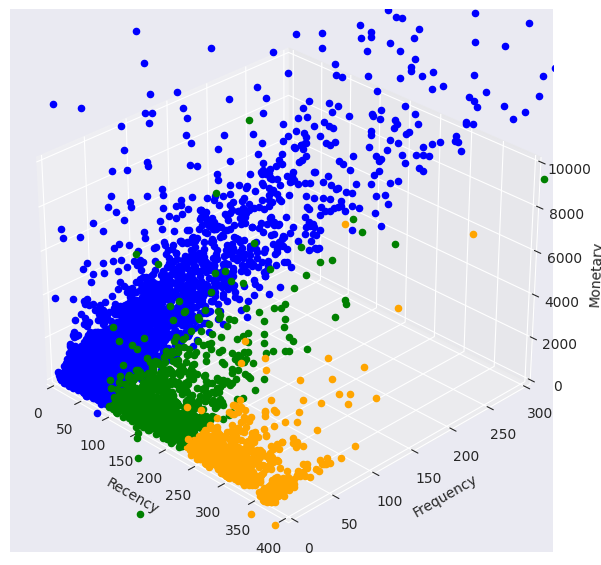

In [ ]:
sns.set_style ("darkgrid")
plt.figure (figsize = (7, 9))
seaborn_plot = plt.axes (projection='3d')
print (type (seaborn_plot))

#plotting all the points ,colour coding them same as that in the bar graph for 3 clusters
for i in range(w.shape[0]):
  if(w[i]==0):
    seaborn_plot.scatter3D (x[i],y[i],z[i],c='b')
  if(w[i]==1):
    seaborn_plot.scatter3D (x[i],y[i],z[i],c='orange')
  if(w[i]==2):
    seaborn_plot.scatter3D (x[i],y[i],z[i],c='g')

# w[i] is never 3 because the because we are generating only 3 clusters
# if(w[i]==3):
# seaborn_plot.scatter3D (x[i],y[i],z[i],c='y')

#The axes for the 3-Dimensions would be x:Recency,y:Frequency and z:Monetory value
seaborn_plot.set_xlabel ('Recency')
seaborn_plot.set_ylabel ('Frequency')
seaborn_plot.set_zlabel ('Monetary')

# scaling the values to necessary levels so that we can make a reasonable plot
seaborn_plot.set_xlim3d(0, 400)
seaborn_plot.set_ylim3d(0, 300)
seaborn_plot.set_zlim3d(0, 10000)
seaborn_plot.view_init(elev=30, azim=-45)
plt.show ()

Clearly the 3-D plot indicates that are our observations are correct.

1.   The leftmost points on the above 3-D plot are the belong to Cluster 0.These customers have low recency and high monetory value and frequency. as observed on the plot.

2.   The rightmost points are Cluster 1 points that have very high recency and very low monetory value and frequency.These are customers that belong to the category that are the most vulnerable to being lost with most of them already lost.

3.   The middle category of customers are low on frequency with a medium recency and decent monetory value. My observation suggests that these customers need to encourages to be more frequent.that will automatically improve the recency and monetory value.

